# Kaggle Study 36일차(spooky)
코드출처 :https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author

목표는 다음과 같습니다.

경쟁 데이터 세트에는 퍼블릭 도메인의 무시무시한 저자가 쓴 소설의 텍스트가 포함되어 있습니다.

1. 에드거 앨런 포(EAP)
2. HP 러브크래프트(HPL)
3. 메리 월스톤크래프트 셸리 (MWS)  
  
목표는 테스트 세트의 문장 작성자를 정확하게 식별하는 것입니다.

노트북의 목표는 다음과 같습니다.

이 노트북에서는 으스스한 작가를 식별하는 데 도움이 되는 다양한 기능을 만들어 보겠습니다.

첫 번째 단계로, 기능 엔지니어링 파트에 깊이 들어가기 전에 몇 가지 기본적인 데이터 시각화 및 청소를 수행할 것입니다.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [2]:
train_df =  pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/spooky/train.csv')
test_df =  pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/spooky/test.csv')
print('Number of rows in train dataset : ',train_df.shape[0])
print('Number of rows in test dataset : ',test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


우리는 저자의 발생 횟수를 확인하여 수업의 균형을 맞출 수 있는지 확인할 수 있습니다.

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


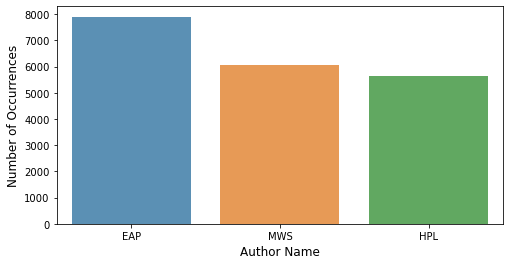

In [4]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Author Name',fontsize=12)
plt.show()

이것은 좋아보입니다. 불균형이 그리 심하지 않습니다. 각 저자의 몇 줄씩 인쇄하여 가능하면 저자의 작문 스타일을 이해하도록 하겠습니다.

In [5]:
grouped_df = train_df.groupby('author')
for name,group in grouped_df :
    print('Author name : ',name )
    cnt = 0
    for ind,row in group.iterrows():
        print(row['text'])
        cnt +=1
        if cnt == 5:
            break
    print('\n')

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

단지 제가 볼 수 있는 것은 텍스트 데이터에 특수 문자들이 꽤 있다는 것입니다. 그래서 이러한 특수문자를 세는 것이 좋은 특징일 수 있습니다. 아마 나중에 만들 수 있을 거예요.

그것말고는, 나는 많은 단서를 가지고 있지 않습니다. 관심 있는 스타일(작성할 수 있는 기능)이 있으면 코멘트에 추가하십시오.

__기능 엔지니어링__:

이제 기능 엔지니어링을 해보겠습니다. 이것은 두 개의 주요 부분으로 구성됩니다.

1. 메타 피쳐 - 단어 수, 중지 단어 수, 문장 부호 수 등과 같은 텍스트에서 추출되는 피쳐입니다.
2. 텍스트 기반 기능 - 빈도, svd, word2vec 등과 같은 텍스트/단어를 직접 기반으로 합니다.

__메타 기능__:

우리는 메타 피처를 만드는 것부터 시작해서 그들이 얼마나 잘 그 으스스한 작가들을 예측하는지 볼 것입니다. 기능 목록은 다음과 같습니다.

1. 텍스트의 단어 수
2. 텍스트의 고유 단어 수
3. 텍스트의 문자 수
4. 중지 단어 수
5. 구두점 수
6. 대소문자의 수
7. 제목 케이스 단어 수
8. 단어의 평균 길이

In [6]:
#단어 개수
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

#특정 단어 개수
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

#문자 개수
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

#중지 단어 개수
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#구두점 수
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

#대소문자 수
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#제목 케이스 단어 수
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#단어 평균 길이
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

이제 예측에 도움이 될 수 있는 몇 가지 새로운 변수를 표시해 보겠습니다.

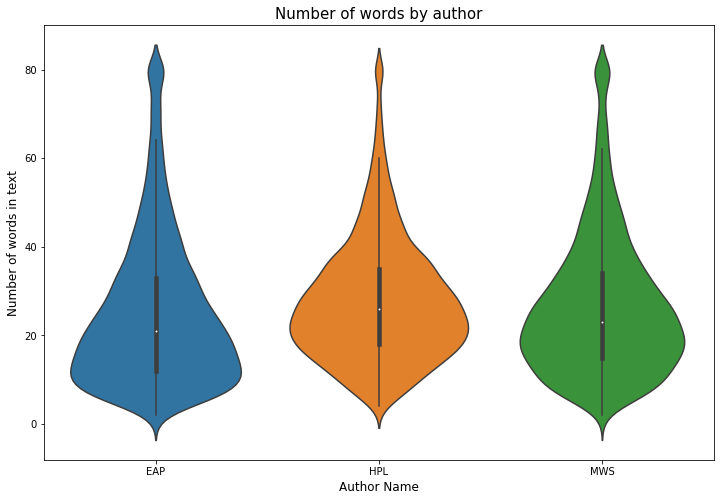

In [8]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

EAP는 MWS나 HPL보다 단어 수가 조금 적은 것 같습니다.

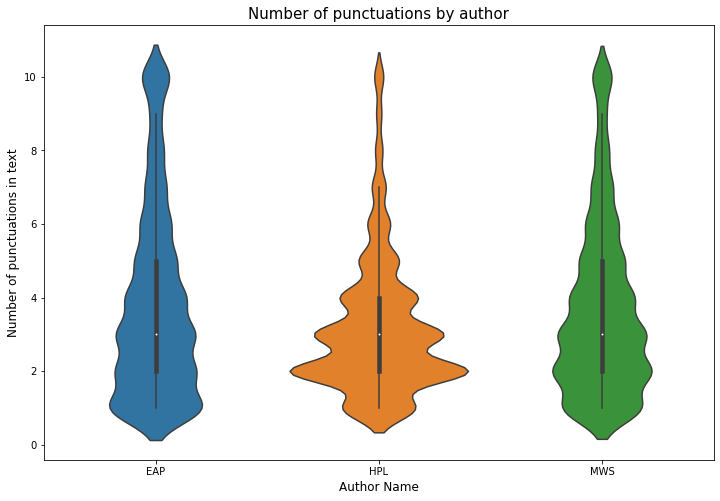

In [9]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

이것 또한 어느 정도 유용한 것 같습니다. 이제 텍스트 기반 기능을 만드는 데 초점을 맞추겠습니다.

먼저 기본 모델을 구축하여 이러한 메타 기능이 어떻게 도움이 되는지 살펴보겠습니다.

In [10]:
#작가들 매핑
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# 잘라낸 변수를 다시 계산
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

이러한 메타 기능만으로도 간단한 XGBoost 모델을 교육할 수 있습니다.

In [11]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

커널 실행 시간을 위해, 우리는 단지 점수에 대한 k-fold 교차 검증의 첫 번째 폴드를 확인할 수 있습니다. 로컬에서 실행되는 동안 'break' 줄을 제거하십시오.

In [12]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[13:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.09384	test-mlogloss:1.09472
[20]	train-mlogloss:1.04663	test-mlogloss:1.05720
[40]	train-mlogloss:1.02368	test-mlogloss:1.03845
[60]	train-mlogloss:1.01109	test-mlogloss:1.02949
[80]	train-mlogloss:0.99824	test-mlogloss:1.01957
[100]	train-mlogloss:0.98938	test-mlogloss:1.01345
[120]	train-mlogloss:0.98209	test-mlogloss:1.00860
[140]	train-mlogloss:0.97603	test-mlogloss:1.00505
[160]	train-mlogloss:0.97088	test-mlogloss:1.00237
[180]	train-mlogloss:0.96619	test-mlogloss:1.00040
[200]	train-mlogloss:0.96141	test-mlogloss:0.99788
[220]	train-mlogloss:0.95745	test-mlogloss:0.99651
[240]	trai

메타 기능만 사용하여 mlog 손실 '0.987'을 얻고 있습니다. 나쁘지 않아요. 이제 다음 중 어떤 기능이 중요한지 살펴보겠습니다.

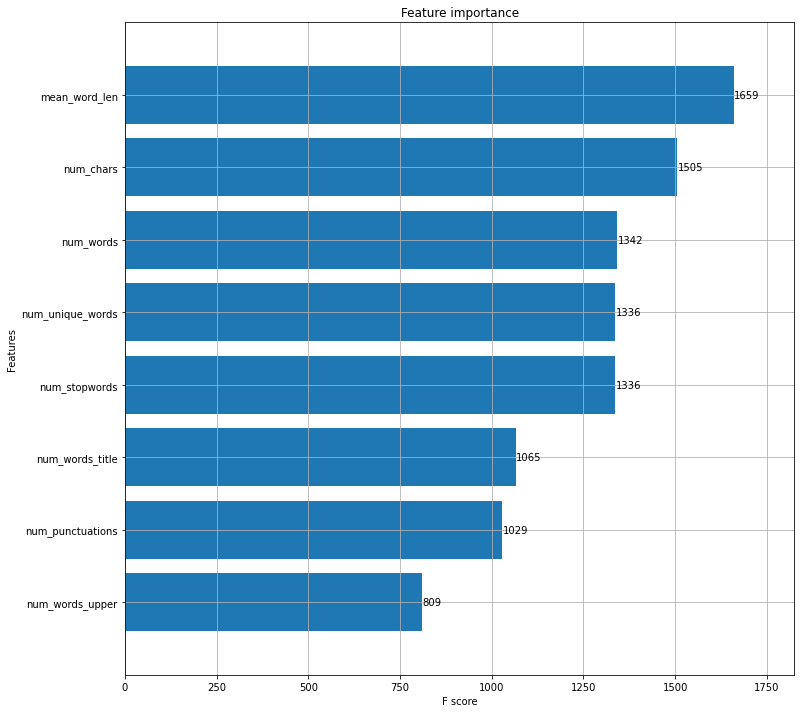

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

문자 수, 평균 단어 길이, 고유 단어 수가 상위 3개 변수로 나타납니다. 이제 텍스트 기반 기능을 만드는 데 초점을 맞추겠습니다.

__텍스트 기반 기능:__

우리가 만들 수 있는 기본적인 특징 중 하나는 텍스트에 있는 단어의 tf-idf 값입니다. 그래서 우리는 그것부터 시작할 수 있습니다.

In [14]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 우리는 tfidf 벡터를 얻었고, 여기 까다로운 부분이 있습니다. tfidf 출력은 희소 행렬이므로 다른 조밀한 특징과 함께 사용해야 한다면 몇 가지 선택사항이 있습니다.

1. tfidf vectorizer에서 상위 'n' 기능(시스템 구성에 따라 다름)을 가져와 조밀한 형식으로 변환하고 다른 기능과 연결할 수 있습니다.
2. 희소 기능만 사용하여 모형을 만든 다음 예측 기능을 다른 조밀한 기능과 함께 특성 중 하나로 사용합니다.  
  
데이터 세트를 기준으로 하면 다른 데이터 세트보다 성능이 더 좋을 수 있습니다. 여기에서는 tfidf의 모든 기능을 사용하는 매우 좋은 점수가 매긴 커널(링크 없음 ㅠㅠ)이 있기 때문에 두 번째 접근 방식을 사용할 수 있습니다.

또한 [Navid Bayes가 이 데이터 세트에서 더 나은 성능을 보이고 있는 것](https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399) 같습니다. 그래서 우리는 훈련하는 것이 더 빠르기 때문에 tfidf 기능을 사용하여 순진한 베이지 모델을 만들 수 있습니다.

In [15]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

Naive Bayes on Word Tfidf Vectorizer:

In [16]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612855


In [17]:
import itertools
from sklearn.metrics import confusion_matrix

# 출처 :  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    이 함수는 confuse matrix를 표시합니다.
    정규화는 'normalize=True'를 설정하여 적용할 수 있습니다.맞아요.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

그래서 많은 인스턴스들이 EAP로 예측되고 그 클래스에 매우 편향되어 있습니다.

__SVD on word TFIDF:__

tfidf 벡터는 희박하기 때문에, 정보를 압축하고 그것을 매우 압축적으로 표현하는 또 다른 방법은 SVD를 통해서입니다. 또한 일반적으로 SVD 기능은 과거 텍스트 기반 대회에서 저에게 좋은 성능을 보여주었습니다. 그래서 워드 tfidf에 svd 기능을 만들어 기능 세트에 추가할 수 있었습니다.

In [18]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

__Naive Bayes on Word Count Vectorizer:__

In [19]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 카운트 벡터라이저 기반 기능을 사용하여 다항식 NB 모델을 구축하겠습니다.

In [20]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측을 새로운 기능으로 추가합니다.
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45091841616567435


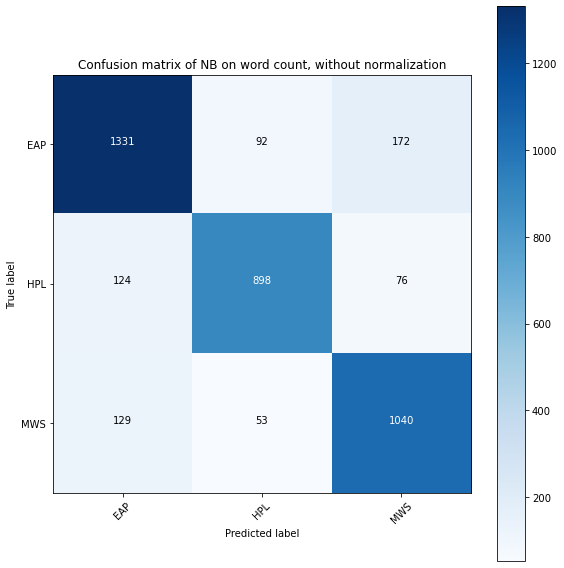

In [21]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

와, 교차 검증 mlog 손실은 0.451인데 tfidf vectorizer 대신 count vectorizer를 사용했죠 이 모델을 사용하는 LB 점수는 0.468입니다. 또한 혼선 행렬이 이전 매트릭스보다 훨씬 좋아 보입니다.

__Naive Bayes on Character Count Vectorizer:__

"데이터 아이볼링"의 한 가지 아이디어는 특수 문자를 세는 것이 도움이 될 수 있다는 것입니다. 특수 문자만 세는 대신 문자 수준의 카운트 벡터라이저를 사용하여 몇 가지 기능을 얻을 수 있습니다. 그 위에다 다항식 NB를 실행할 수 있습니다.

In [22]:
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.7507639226818825


교차점수는 매우 높고 3.75입니다. 그러나 이것은 워드 레벨 기능과는 다른 정보를 추가할 수 있으므로 최종 모델에도 사용할 수 있습니다.

__Naive Bayes on Character Tfidf Vectorizer:__

피디 벡터라이저의 성격에 대한 순진한 베이지 예측도 해 보겠습니다.

In [23]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


__SVD on Character TFIDF:__  

또한 문자 tfidf 기능에 svd 기능을 생성하여 모델링에 사용할 수도 있습니다.

In [24]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

__XGBoost model:__  
이제 이러한 새로운 변수를 사용하여 xgboost 모델을 다시 실행하고 결과를 평가할 수 있습니다.

In [25]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[19:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.00354	test-mlogloss:1.00354
[20]	train-mlogloss:0.40979	test-mlogloss:0.41471
[40]	train-mlogloss:0.33858	test-mlogloss:0.35061
[60]	train-mlogloss:0.31308	test-mlogloss:0.33272
[80]	train-mlogloss:0.29566	test-mlogloss:0.32391
[100]	train-mlogloss:0.28243	test-mlogloss:0.31827
[120]	train-mlogloss:0.27152	test-mlogloss:0.31475
[140]	train-mlogloss:0.26187	test-mlogloss:0.31187
[160]	train-mlogloss:0.25342	test-mlogloss:0.30982
[180]	train-mlogloss:0.24557	test-mlogloss:0.30863
[200]	train-mlogloss:0.23779	test-mlogloss:0.30748
[220]	train-mlogloss:0.23123	test-mlogloss:0.30644
[240]	trai

__이 경우 Val 점수가 0.3055이고 LB 점수가 0.32xx이므로__ 모든 폴드에서 실행하면 더 좋은 점수를 얻을 수 있습니다. 이제 중요한 변수들을 다시 한번 확인해 보겠습니다.

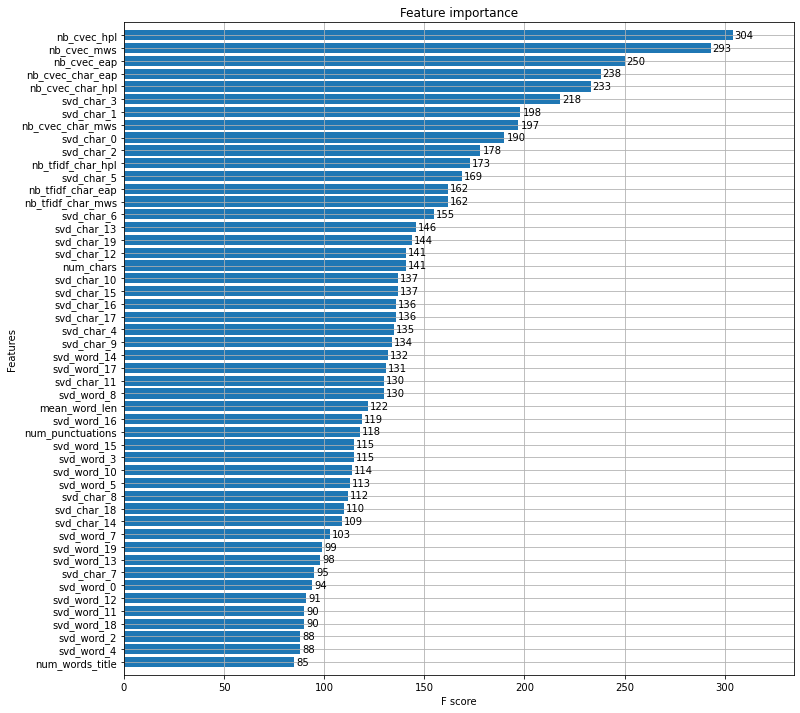

In [26]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

나이브 베이즈 특징은 역시 최고의 특징입니다. 이제 혼동 행렬을 통해 오분류 오류를 살펴보겠습니다.

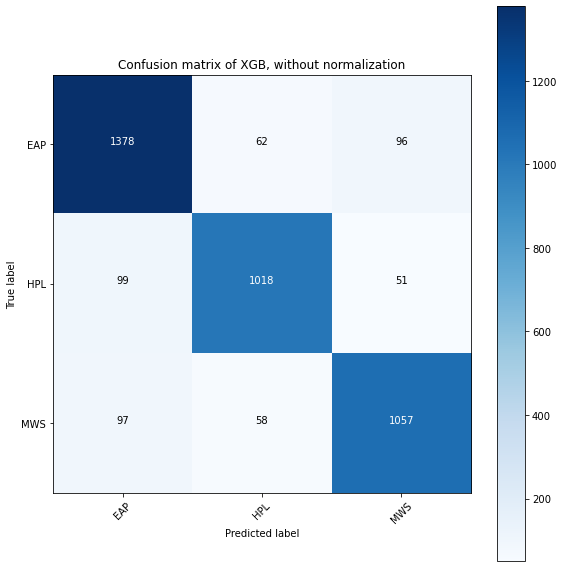

In [27]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

EAP와 MWS는 다른 것보다 자주 잘못 분류되는 것 같습니다. 이 쌍에 대한 예측을 개선하는 기능을 잠재적으로 생성할 수 있습니다.

이 FE 노트북의 다음 단계는 다음과 같습니다.

1. 단어 임베딩 기반 기능을 사용합니다.
2. 기타 메타 피쳐(있는 경우)입니다.
3. 문장에 감상이 있습니다.  
  
__추가 개선을 위한 아이디어:__

- tfidf 및 카운트 벡터라이저에 대한 매개 변수 튜닝입니다.
- 나이브 배이즈 및 XGB 모델에 대한 매개 변수 튜닝입니다.
- 다른 모델과 결합/쌓입니다.